In [1]:
import numpy as np
import matplotlib
import numpy as np
import scipy.stats as sst
import scipy as sp
import matplotlib.pylab as plt
import seaborn as sns
from math import *
import scipy.spatial.distance as ssp
import pandas as pd


import helpers.theo_variogram_fct as vario
import helpers.th_cov_func as nest_vario
from ipywidgets import interact,Checkbox,Text,VBox

import helpers.kriging as kri
import helpers.variogram as variokri

from IPython.display import Image
from IPython.display import display
from IPython.display import SVG

In [2]:
#import data iron concentration
data = pd.read_csv("data_iquique/data_fe.csv")
xyz = data.to_numpy()
print(xyz[:3])

#reduce coordenate numbers
xyz[:,0]= xyz[:,0] - min(xyz[:,0])
xyz[:,1]= xyz[:,1] - min(xyz[:,1])
print(xyz[:3])

[[7.787318e+06 4.347360e+05 5.970000e+00]
 [7.782211e+06 4.350980e+05 9.450000e+00]
 [7.782877e+06 4.403180e+05 8.040000e+00]]
[[1.09058e+05 5.44060e+04 5.97000e+00]
 [1.03951e+05 5.47680e+04 9.45000e+00]
 [1.04617e+05 5.99880e+04 8.04000e+00]]


In [3]:
data = pd.read_csv("data_iquique/data_fe.csv")
xyz = data.to_numpy()
print(xyz)

[[7.787318e+06 4.347360e+05 5.970000e+00]
 [7.782211e+06 4.350980e+05 9.450000e+00]
 [7.782877e+06 4.403180e+05 8.040000e+00]
 ...
 [7.689429e+06 4.962810e+05 4.980000e+00]
 [7.690743e+06 4.975460e+05 4.390000e+00]
 [7.702317e+06 4.913270e+05 5.400000e+00]]


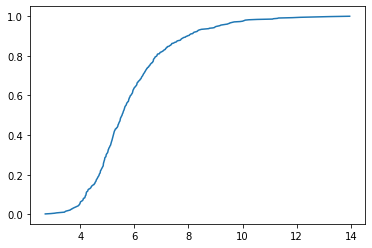

In [4]:
z = xyz[:,2]
def function_cdf(z):
    s = np.sort(z)
    z_values = np.unique(s)
    pdf = []
    for i in range(len(z_values)-1):
        pdf.append(len(z[(s >= z_values[i]) & (s < z_values[i+1])])/len(s))
    cdf = np.cumsum(pdf)
    cdf = np.append(cdf,1)
    return z_values, cdf

values_cdf, cdf = function_cdf(z)

plt.figure()
plt.plot(values_cdf, cdf)

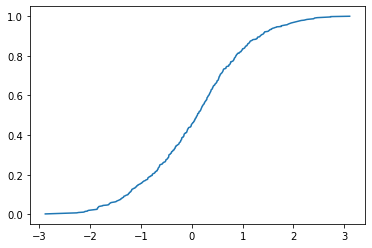

In [5]:
normal_data = np.array(np.random.normal(0,1,len(z)))
values_cdf_normal, cdf_normal = function_cdf(normal_data)

plt.figure()
plt.plot(values_cdf_normal, cdf_normal)

In [6]:
norm_z = []
for value in z:
    pos = np.where(values_cdf==value)[0][0]
    inter = sp.interpolate.interp1d(cdf_normal,values_cdf_normal)
    norm_z.append(inter(cdf[pos]))
norm_z = np.array(norm_z)
        

(560, 2)


Text(0.5, 1.0, 'Scatter plot of sample location')

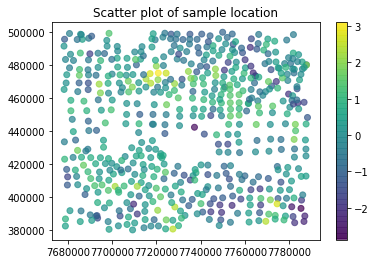

In [7]:
#Scatter plot of samples
xy = xyz[:,0:2]
print(xy.shape)

x = xyz[:,0] #in case of...
y = xyz[:,1]
# z = xyz[:,2]
z = norm_z
plt.scatter(x,
           y,
           c=z,
           alpha=0.7)
plt.colorbar()
plt.title('Scatter plot of sample location')

155400.20058223864


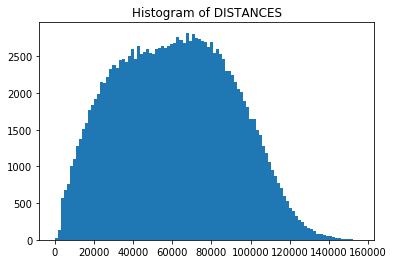

In [8]:
H = ssp.pdist(xy, metric='euclidean')

D = ssp.squareform(H)
plt.hist(H, bins=100)
plt.title("Histogram of DISTANCES")
print(max(H))

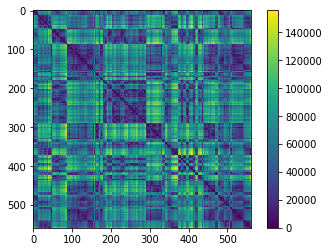

In [9]:
plt.imshow(D)
plt.colorbar()

### Correlogram

In [10]:
n = np.linspace(1000,30000,30)
bins = np.array(n)
print(bins)
print(type(bins))

[ 1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000. 10000.
 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000. 20000.
 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000. 30000.]
<class 'numpy.ndarray'>


In [11]:
ixs = []    # for measurement values at point 0
ixs_h = []  # for measurement values at point 1
rs = []     # for rs in each bin
d_mean = [] # for mean distances

ix = np.array(np.where(np.logical_and(D>bins[0], D<=bins[1])))
print(ix.shape)

(2, 50)


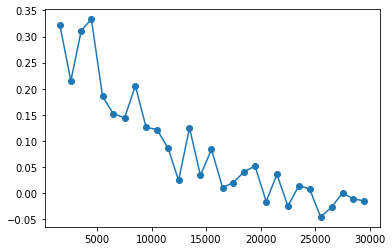

In [12]:
F = z

for cur_i in range(0, len(bins)-1):
    ix = np.where(np.logical_and(D>bins[cur_i], D<=bins[cur_i+1]))
    d_mean.append(D[ix].mean())
    F_0 = F[ix[0]]
    F_1 = F[ix[1]]
    r = np.corrcoef(F_0, F_1)[1,0]
    rs.append(r)
    ixs.append(F_0)
    ixs_h.append(F_1)

#plot
plt.plot(d_mean,
         rs,
        'o-')

### Variogram

In [13]:
Z1, Z2 = np.meshgrid(F, F)
sem_var = (Z1-Z2)**2.
sem_vars = []
co_vars = []
sem_vars_v2 = []
n_pts = []

for cur_i_bin, cur_bin in enumerate(bins[:-1]):
    #print cur_i_bin, cur_bin
    ix = np.where(np.logical_and(D>bins[cur_i_bin], D<=bins[cur_i_bin+1]))
#     print len(ix)
#     print "  ", ix[0].shape, ix[0].min(), ix[0].max()
#     print "  ", ix[1].shape, ix[1].min(), ix[1].max()
    
    ## do it via the prepared large matrices
    sem_var_cur = np.sum(sem_var[ix])/(2.0 * ix[0].shape[0])
    #print sem_var_cur
    sem_vars.append(sem_var_cur)
    
    #print"      ",  ix[0].shape[0]
    sem_var_v2 = np.sum((F[ix[1]] - F[ix[0]])**2)/(2.0 * ix[0].shape[0])
    sem_vars_v2.append(sem_var_v2)
    
    mean = F[ix[1]].mean()
    covar = np.sum((F[ix[1]]-mean)* (F[ix[0]]-mean))/( ix[0].shape[0])
    co_vars.append(covar)

(0.0, 1.1122965707497439)

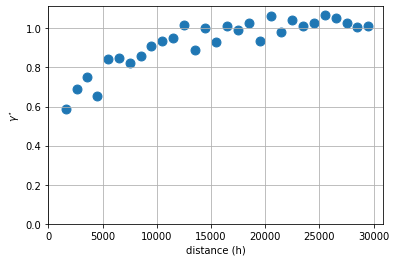

In [14]:
centers =  (bins[:-1] + bins[1:])/2
plt.scatter(d_mean, np.array(sem_vars), s=80)
plt.grid(True)
plt.xlabel('distance (h)')
plt.ylabel('$\gamma^{\star}$')
plt.xlim(0.0,)
plt.ylim(0.0,)

In [ ]:
# var = np.zeros((len(coord_xy),len(coord_xy)))
# for i in range(coord_xy):
#     for j in range(i, coord_xy):
#         var[i,j] = (data[i] - data[j])**2.

In [ ]:
# dists_ix = np.triu_indices(D.shape[0], 0)
# dists_triu = D[dists_ix]

# vars_ix = np.triu_indices(var.shape[0], 0)
# vars_triu = var[vars_ix]

# plt.scatter(dists_triu, vars_triu, s=40, facecolors='none', edgecolors='b')
# plt.xlabel("distance")
# plt.ylabel("variance")

In [ ]:
# x = np.linspace(0,490,num=50)
# y = np.linspace(0,490,num=50)
# xx , yy = np.mesh(x,y)

### Random path function

In [ ]:
# ### EN DESARROLLO!!!

# delta_x = 10        #meters
# delta_y = delta_x   #meters. To keep square cells
# nx = 1 + np.round(max(x)/delta_x)       #number of cell in x-axis
# ny = 1 + np.round(max(y)/delta_y)        #number of cell in y-axis

# n_sample = 150 #sample amount
# A = np.random.rand(nx,ny) #Define nx x ny dimension initial matrix with values in a normal distribution u=0, var=1
# sigma = 1 #quizas esto no sea necesario
# mu = 0    #quizas esto no sea necesario
# print (A.shape)


# # fuction to create random vector of sample locations
# def random_loc_vec(nx,l): # range of number [0,nx)
#     loc_vector = np.random.randint(nx, size=(l,2))
#     unique = np.unique(loc_vector, axis=0)
#     i=1
#     while len(unique) < len(loc_vector) and i<100:     #i is to avoid infinite loop in case.
#         dif = len(loc_vector) - len(unique)
#         add = np.random.randint(nx, size=(dif,2))
#         unique = np.concatenate((unique,add), axis=0)
#         unique = np.unique(unique, axis=0)
#         i+=1
#     unique = np.array(unique)
#     return unique

# #vector with unique location
# location_v= random_loc_vec(nx, n_sample)
# print(location_v.shape)


# #get global coordenates
# coord_xy = np.array(np.zeros((len(location_v),2)))
# for i in range(len(location_v)):
#     coord_xy[i][0] = location_v[i][0]*delta_x*3/2 
#     coord_xy[i][1] = location_v[i][1]*delta_y*3/2
# # print(coord_xy[:3])

# #Get z values vector
# z_values = np.matrix([A[i[0], i[1]] for i in location_v])  #np.matrix to get a matrix transposable
# z_values = np.array(z_values.T)

# #unify XYZ real world coordenates matrix
# xyz= np.concatenate((coord_xy, z_values), axis=1)

In [ ]:
models = {'Exponential': vario.ExponentialVariogram,
          'Spherical': vario.SphericalVariogram,
          'Gaussian': vario.GaussianVariogram,
          'Linear': vario.LinearVariogram}

# plotting for function for individual models
def plot_varmodel(Sill, Range, Model):
    v_model = Model(Sill, Range, h)
    plt.plot(h,v_model, c='red') # Model Variogram
    plt.scatter(centers, np.array(sem_vars), s=80) # Empirical Variogram
    plt.xlabel('distance')
    plt.ylabel('$\\gamma$')
    plt.xlim(0.,max(h))
    plt.ylim(0.,)
    plt.grid(True)
    plt.show()

In [ ]:
# Determine first guess of sill and range from empirical variogram
var_sill = np.round(np.max(np.array(sem_vars)),2)
h = np.linspace(0, max(centers),  int(max(centers)/10.))
var_range = np.round(np.max(np.array(centers)),2)

In [ ]:
# Trigger Interactive Plot
import importlib
importlib.reload(vario)
interact(plot_varmodel,
         Sill =(var_sill/2,var_sill*2,0.05),
         Range = (0,max(h), max(h)/100),
         Model = models)

In [15]:
xx_matrix = np.arange(min(x),7788251.,50)
yy_matrix = np.arange(380300,499951,50)

In [16]:
i_coords, j_coords = np.meshgrid(xx_matrix, yy_matrix, indexing='ij')
coords = np.column_stack((np.concatenate(i_coords), np.concatenate(j_coords)))

In [17]:
controls = np.column_stack((x,y))
print(controls)

[[7787318.  434736.]
 [7782211.  435098.]
 [7782877.  440318.]
 ...
 [7689429.  496281.]
 [7690743.  497546.]
 [7702317.  491327.]]


In [ ]:
z

In [19]:
# Variogram
variogram_paras = [0.97,   # sill
                   3245]   # Range

fitted_variogram = vario.ExponentialVariogram({'sill': variogram_paras[0],
                                                'range': variogram_paras[1]})

                                  
ok_results = []
ok_result = kri.krige_ok(controls
                       , coords
                       , z
                       , fitted_variogram
                       , len(z)
                       , verbose = True)
print ('ID \t x \t y \t est(z)')
for i, result in enumerate(ok_result):
    print('{0:2d}\t{1:3.2f}\t{2:3.2f}\t{3:3.2f}'.format(i, targets[i][0], targets[i][1], result[1]))
    # the weights are stored in results[0] but not saved here
    ok_results.append([result[1], result[2]])
                                               
                            
print(ok_results)

TypeError: ExponentialVariogram() missing 2 required positional arguments: 'var_range' and 'dist'